### Import the required libraries and modules:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/HRF_OD_4

Mounted at /content/gdrive
/content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/HRF_OD_4


### Unzip the data:

In [ ]:
# !unzip new_data.zip

### Construct the Model:

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters, strides=2):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D(strides)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, strides=2):
    x = Conv2DTranspose(num_filters, (2, 2), strides=strides, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 2]):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters[0], strides=strides[0])
    s2, p2 = encoder_block(p1, num_filters[1], strides=strides[1])
    s3, p3 = encoder_block(p2, num_filters[2], strides=strides[2])
    s4, p4 = encoder_block(p3, num_filters[3], strides=strides[3])

    b1 = conv_block(p4, num_filters[4])

    d1 = decoder_block(b1, s4, num_filters[3], strides=strides[3])
    d2 = decoder_block(d1, s3, num_filters[2], strides=strides[2])
    d3 = decoder_block(d2, s2, num_filters[1], strides=strides[1])
    d4 = decoder_block(d3, s1, num_filters[0], strides=strides[0])

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

### Adding the Metrics:

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def DiceBCELoss(y_true, y_pred):

    inputs = tf.keras.layers.Flatten()(y_true)
    targets = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(inputs * targets)
    dice_loss = 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    BCE = tf.keras.losses.BinaryCrossentropy()
    Dice_BCE = BCE(inputs, targets) + dice_loss

    return Dice_BCE



### Training the Model:

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 4
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model1.h5")
csv_path = os.path.join("files", "data1.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model1 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 384], strides=[2, 2, 2, 2])

model1.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model1.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 252 - 252
Valid: 9 - 9
Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 1.1201 - dice_coef: 0.1318 - iou: 0.0717 - recall: 0.7844 - precision: 0.2398
Epoch 1: val_loss improved from inf to 2.55737, saving model to files/model1.h5
63/63 [==============================] - 150s 2s/step - loss: 1.1201 - dice_coef: 0.1318 - iou: 0.0717 - recall: 0.7844 - precision: 0.2398 - val_loss: 2.5574 - val_dice_coef: 0.0248 - val_iou: 0.0125 - val_recall: 1.0000 - val_precision: 0.0123 - lr: 1.0000e-04
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 0.8392 - dice_coef: 0.2536 - iou: 0.1457 - recall: 0.8856 - precision: 0.8131
Epoch 2: val_loss improved from 2.55737 to 1.20734, saving model to files/model1.h5
63/63 [==============================] - 65s 1s/step - loss: 0.8392 - dice_coef: 0.2536 - iou: 0.1457 - recall: 0.8856 - precision: 0.8131 - val_loss: 1.2073 - val_dice_coef: 0.0249 - val_iou: 0.0126 - val_recall: 0.0000e+00 - val_precision: 0.0000e+0

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 4
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model2.h5")
csv_path = os.path.join("files", "data2.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model2 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 512], strides=[2, 2, 2, 2])

model2.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model2.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 252 - 252
Valid: 9 - 9
Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 1.1203 - dice_coef: 0.1320 - iou: 0.0718 - recall: 0.7856 - precision: 0.2399
Epoch 1: val_loss improved from inf to 2.40501, saving model to files/model2.h5
63/63 [==============================] - 200s 3s/step - loss: 1.1203 - dice_coef: 0.1320 - iou: 0.0718 - recall: 0.7856 - precision: 0.2399 - val_loss: 2.4050 - val_dice_coef: 0.0236 - val_iou: 0.0120 - val_recall: 1.0000 - val_precision: 0.0124 - lr: 1.0000e-04
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 0.8396 - dice_coef: 0.2534 - iou: 0.1456 - recall: 0.8869 - precision: 0.8096
Epoch 2: val_loss improved from 2.40501 to 1.30973, saving model to files/model2.h5
63/63 [==============================] - 62s 985ms/step - loss: 0.8396 - dice_coef: 0.2534 - iou: 0.1456 - recall: 0.8869 - precision: 0.8096 - val_loss: 1.3097 - val_dice_coef: 0.0295 - val_iou: 0.0150 - val_recall: 0.1298 - val_precision: 0.5002 - l

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 4
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model3.h5")
csv_path = os.path.join("files", "data3.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model3 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 768], strides=[2, 2, 2, 2])

model3.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model3.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 252 - 252
Valid: 9 - 9
Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 1.1182 - dice_coef: 0.1328 - iou: 0.0723 - recall_1: 0.7886 - precision_1: 0.2415
Epoch 1: val_loss improved from inf to 3.15070, saving model to files/model3.h5
63/63 [==============================] - 67s 1s/step - loss: 1.1182 - dice_coef: 0.1328 - iou: 0.0723 - recall_1: 0.7886 - precision_1: 0.2415 - val_loss: 3.1507 - val_dice_coef: 0.0245 - val_iou: 0.0124 - val_recall_1: 1.0000 - val_precision_1: 0.0123 - lr: 1.0000e-04
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 0.8378 - dice_coef: 0.2543 - iou: 0.1462 - recall_1: 0.8878 - precision_1: 0.8186
Epoch 2: val_loss improved from 3.15070 to 1.19875, saving model to files/model3.h5
63/63 [==============================] - 64s 1s/step - loss: 0.8378 - dice_coef: 0.2543 - iou: 0.1462 - recall_1: 0.8878 - precision_1: 0.8186 - val_loss: 1.1988 - val_dice_coef: 0.0251 - val_iou: 0.0127 - val_recall_1: 0.0000e+00 - val

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model4.h5")
csv_path = os.path.join("files", "data4.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model4 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 2])

model4.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model4.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 252 - 252
Valid: 9 - 9
Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.9939 - dice_coef: 0.1841 - iou: 0.1035 - recall_2: 0.8231 - precision_2: 0.3682
Epoch 1: val_loss improved from inf to 1.22558, saving model to files/model4.h5
126/126 [==============================] - 81s 538ms/step - loss: 0.9939 - dice_coef: 0.1841 - iou: 0.1035 - recall_2: 0.8231 - precision_2: 0.3682 - val_loss: 1.2256 - val_dice_coef: 0.0242 - val_iou: 0.0122 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.7569 - dice_coef: 0.3139 - iou: 0.1873 - recall_2: 0.8951 - precision_2: 0.8185
Epoch 2: val_loss improved from 1.22558 to 1.06847, saving model to files/model4.h5
126/126 [==============================] - 69s 546ms/step - loss: 0.7569 - dice_coef: 0.3139 - iou: 0.1873 - recall_2: 0.8951 - precision_2: 0.8185 - val_loss: 1.0685 - val_dice_coef: 0.0229 - val_iou: 0.0116 - val_reca

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 1
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model5.h5")
csv_path = os.path.join("files", "data5.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model5 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1280], strides=[2, 2, 2, 2])

model5.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model5.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 252 - 252
Valid: 9 - 9
Epoch 1/50
252/252 [==============================] - ETA: 0s - loss: 0.8870 - dice_coef: 0.2440 - iou: 0.1425 - recall_3: 0.8761 - precision_3: 0.5023
Epoch 1: val_loss improved from inf to 1.06867, saving model to files/model5.h5
252/252 [==============================] - 84s 306ms/step - loss: 0.8870 - dice_coef: 0.2440 - iou: 0.1425 - recall_3: 0.8761 - precision_3: 0.5023 - val_loss: 1.0687 - val_dice_coef: 0.0229 - val_iou: 0.0116 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
252/252 [==============================] - ETA: 0s - loss: 0.6361 - dice_coef: 0.4145 - iou: 0.2651 - recall_3: 0.8990 - precision_3: 0.8442
Epoch 2: val_loss improved from 1.06867 to 0.82707, saving model to files/model5.h5
252/252 [==============================] - 79s 314ms/step - loss: 0.6361 - dice_coef: 0.4145 - iou: 0.2651 - recall_3: 0.8990 - precision_3: 0.8442 - val_loss: 0.8271 - val_dice_coef: 0.2176 - val_iou: 0.1337 - val_reca

### Evaluating the Model:

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.models import load_model

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model1.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score1 = [s[1:] for s in SCORE]
score1 = np.mean(score1, axis=0)
print(f"Accuracy: {score1[0]:0.5f}")
print(f"F1: {score1[1]:0.5f}")
print(f"Jaccard: {score1[2]:0.5f}")
print(f"Recall: {score1[3]:0.5f}")
print(f"Precision: {score1[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score1.csv")

100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

Accuracy: 0.99781
F1: 0.90938
Jaccard: 0.83830
Recall: 0.97776
Precision: 0.85647


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model2.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score2 = [s[1:] for s in SCORE]
score2 = np.mean(score2, axis=0)
print(f"Accuracy: {score2[0]:0.5f}")
print(f"F1: {score2[1]:0.5f}")
print(f"Jaccard: {score2[2]:0.5f}")
print(f"Recall: {score2[3]:0.5f}")
print(f"Precision: {score2[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score2.csv")

100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

Accuracy: 0.99803
F1: 0.91694
Jaccard: 0.84914
Recall: 0.97559
Precision: 0.86903


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model3.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score3 = [s[1:] for s in SCORE]
score3 = np.mean(score3, axis=0)
print(f"Accuracy: {score3[0]:0.5f}")
print(f"F1: {score3[1]:0.5f}")
print(f"Jaccard: {score3[2]:0.5f}")
print(f"Recall: {score3[3]:0.5f}")
print(f"Precision: {score3[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score3.csv")

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

Accuracy: 0.99792
F1: 0.91099
Jaccard: 0.83888
Recall: 0.97244
Precision: 0.86113


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model4.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score4 = [s[1:] for s in SCORE]
score4 = np.mean(score4, axis=0)
print(f"Accuracy: {score4[0]:0.5f}")
print(f"F1: {score4[1]:0.5f}")
print(f"Jaccard: {score4[2]:0.5f}")
print(f"Recall: {score4[3]:0.5f}")
print(f"Precision: {score4[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score4.csv")

100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

Accuracy: 0.99812
F1: 0.91152
Jaccard: 0.84103
Recall: 0.92721
Precision: 0.90848


In [ ]:
""" Save the results in this folder """
# create_dir("results")

""" Load the model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
model = load_model("files/model5.h5", compile=False)

""" Load the dataset """
dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.split("/")[-1].split(".")[0]

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    """ Saving the images """
    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    y_pred = y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

score5 = [s[1:] for s in SCORE]
score5 = np.mean(score5, axis=0)
print(f"Accuracy: {score5[0]:0.5f}")
print(f"F1: {score5[1]:0.5f}")
print(f"Jaccard: {score5[2]:0.5f}")
print(f"Recall: {score5[3]:0.5f}")
print(f"Precision: {score5[4]:0.5f}")

""" Saving """
df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score5.csv")

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

Accuracy: 0.99469
F1: 0.69909
Jaccard: 0.59298
Recall: 0.72637
Precision: 0.73720


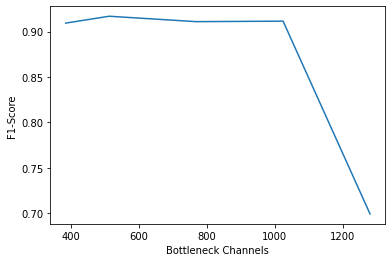

In [ ]:
import matplotlib.pyplot as plt

z_dim = 32
channels = [384, 512, 768, 1024, 1280]
final_score = [score1[1], score2[1], score3[1], score4[1], score5[1]]

plt.plot(channels, final_score)  
plt.xlabel("Bottleneck Channels")
plt.ylabel("F1-Score")
plt.show()  